In [878]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv')

In [841]:
data.shape


(1460, 81)

In [842]:
num_data = data.select_dtypes(include='number')

num_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [843]:
analysis_data = num_data.filter(['GrLivArea', 'SalePrice'], axis=1)
analysis_data

,GrLivArea,SalePrice
0,1710,208500
1,1262,181500
2,1786,223500
3,1717,140000
4,2198,250000
...,...,...
1455,1647,175000
1456,2073,210000
1457,2340,266500
1458,1078,142125


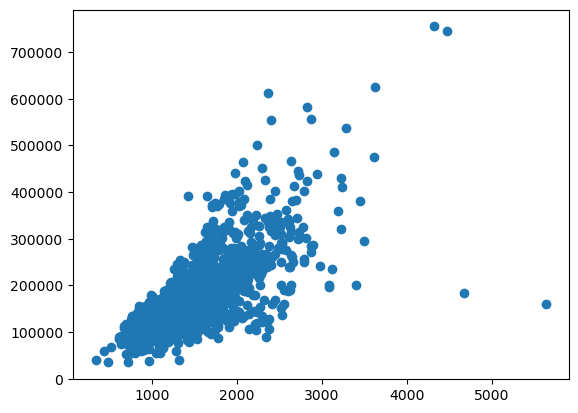

In [844]:
plt.scatter(x=analysis_data.GrLivArea, y=analysis_data.SalePrice)

plt.show()

<Axes: xlabel='GrLivArea'>

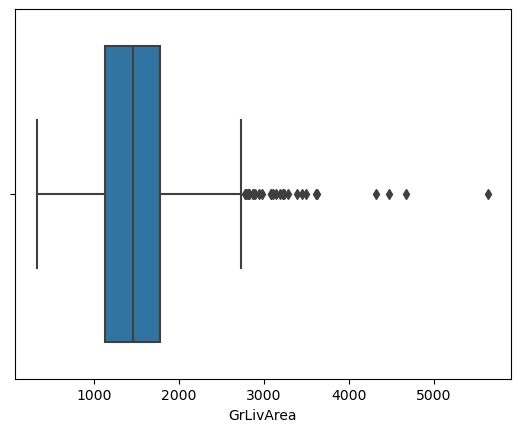

In [845]:
sns.boxplot(x=analysis_data.GrLivArea)


<Axes: ylabel='SalePrice'>

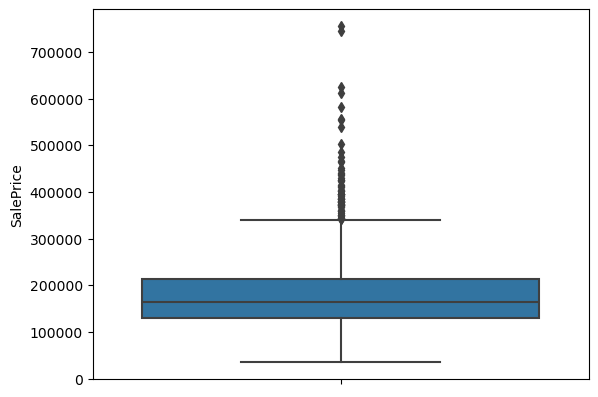

In [846]:
sns.boxplot(y=analysis_data.SalePrice)

In [847]:
z = np.abs(stats.zscore(analysis_data.SalePrice))

print(np.where(z < 2))

(array([   0,    1,    2, ..., 1457, 1458, 1459], dtype=int64),)


In [848]:
def remove_outliers(data: pd.DataFrame, column: str):
    Q1 = np.percentile(column, 25, method='midpoint')
    Q3 = np.percentile(column, 75, method='midpoint')
    
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    upper_array = np.where(column >= upper_bound)[0]
    lower_array = np.where(column <= lower_bound)[0]
    
    new_df = data.drop(index=upper_array, inplace=True)
    new_df = data.drop(index=lower_array, inplace=True)
    
    return new_df

In [849]:
clean = analysis_data[(np.abs(stats.zscore(analysis_data)) < 3).all(axis=1)]


<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

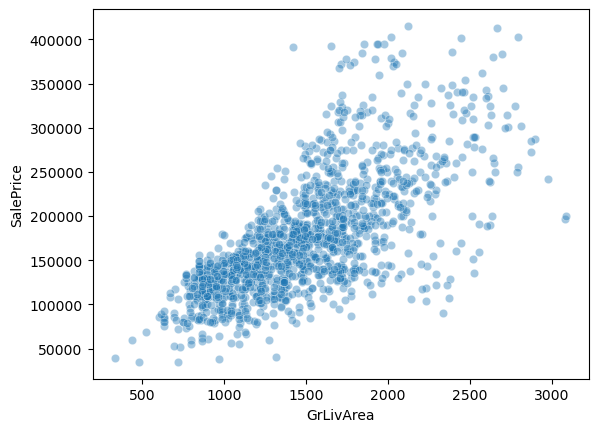

In [850]:
sns.scatterplot(x=clean.GrLivArea, y=clean.SalePrice, alpha=0.4)

<Axes: xlabel='SalePrice', ylabel='Count'>

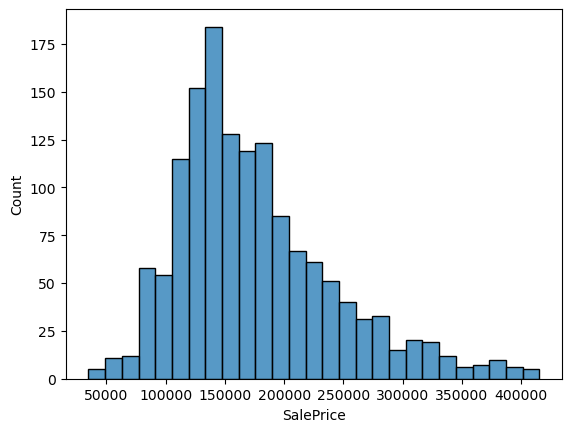

In [851]:
sns.histplot(clean.SalePrice)

<Axes: xlabel='GrLivArea', ylabel='Count'>

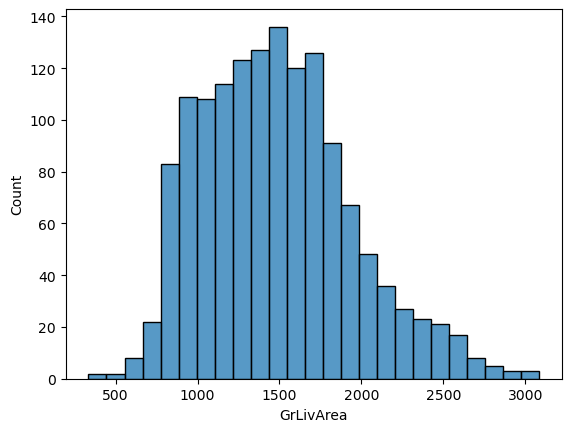

In [852]:
sns.histplot(clean.GrLivArea)

<Axes: >

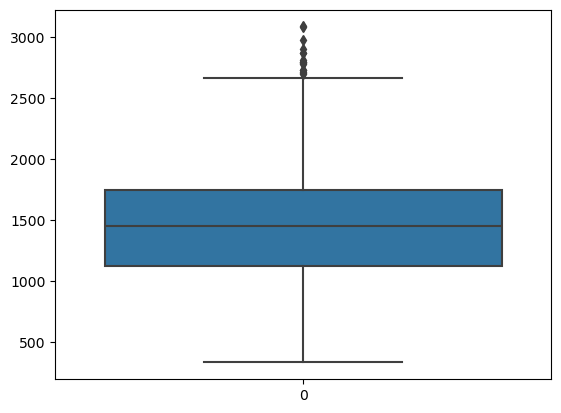

In [853]:
sns.boxplot(clean.GrLivArea)

In [854]:

def z_score_outlier_cleaner(data: pd.DataFrame, z_score_threshold:int, columns_to_keep: [str]) -> pd.DataFrame:
    
    numerical_data = data.select_dtypes(include='number')
    

    z_scores = np.abs(stats.zscore(analysis_data))
    
    
    #z_scores = np.where(z_scores < z_score_threshold)
    
    removed_outliers = numerical_data[(z_scores < z_score_threshold).all(axis=1)]
    
    clean_data = removed_outliers.filter(columns_to_keep, axis=1)
    
    clean_data.to_numpy()
    
    return clean_data
    


In [855]:
cleansed = z_score_outlier_cleaner(data, 3, ['GrLivArea', 'SalePrice'])

cleansed.to_numpy()

array([[  1710, 208500],
       [  1262, 181500],
       [  1786, 223500],
       ...,
       [  2340, 266500],
       [  1078, 142125],
       [  1256, 147500]], dtype=int64)

In [856]:
FloorArea = np.array(cleansed['GrLivArea']).reshape(-1, 1) # cleansed[['GrLivArea']]

SalePrice = np.array(cleansed['SalePrice']).reshape(-1, 1)

Floor_train, Floor_test, Sale_train, Sale_test = train_test_split(FloorArea, SalePrice, test_size=0.2, random_state=None)


Coefficients: 
 [[99.99844304]]
Mean squared error: 2488216720.47718
R2 Score: 0.46913315283763846


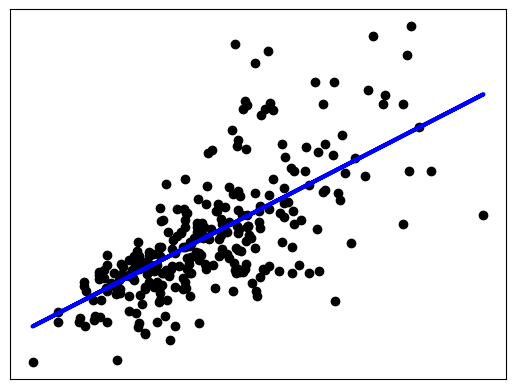

In [857]:
model = linear_model.LinearRegression()

model_fit = model.fit(Floor_train, Sale_train)

model_pred = model.predict(Floor_test)

print(f"Coefficients: \n {model.coef_}")
print(f"Mean squared error: {mean_squared_error(Sale_test, model_pred)}")
print(f"R2 Score: {r2_score(Sale_test, model_pred)}")


plt.scatter(Floor_test, Sale_test, color='black')
plt.plot(Floor_test, model_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Need to get this working, predicted values are playing up

In [858]:
cleansed['predicted_value'] = model.predict(FloorArea)


cleansed['residuals'] = cleansed['SalePrice'] - cleansed['predicted_value'] 

cleansed

,GrLivArea,SalePrice,predicted_value,residuals
0,1710,208500,198464.589472,10035.410528
1,1262,181500,153665.286989,27834.713011
2,1786,223500,206064.471143,17435.528857
3,1717,140000,199164.578573,-59164.578573
4,2198,250000,247263.829675,2736.170325
...,...,...,...,...
1455,1647,175000,192164.687560,-17164.687560
1456,2073,210000,234764.024295,-24764.024295
1457,2340,266500,261463.608587,5036.391413
1458,1078,142125,135265.573470,6859.426530


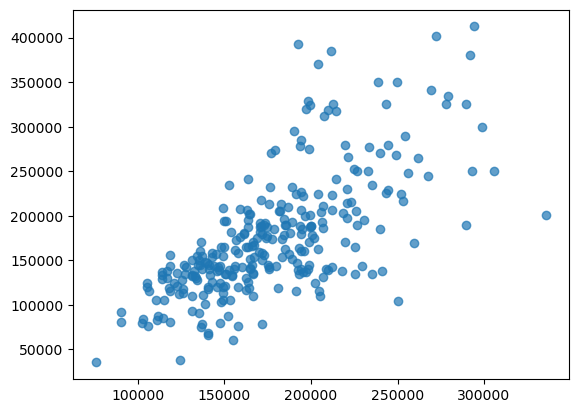

In [859]:
actual_values = Sale_test

plt.scatter(model_pred, actual_values, alpha=0.7)

plt.show()

In [860]:
numerical_data = data.select_dtypes(include='number')

corr = numerical_data.corr()

print(corr['SalePrice'].sort_values(ascending=False)[:10], '\n')

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 



In [861]:
multi_regression_data = z_score_outlier_cleaner(data, 3, ['GrLivArea', 'SalePrice', 'OverallQual'])

multi_regression_data

,GrLivArea,SalePrice,OverallQual
0,1710,208500,7
1,1262,181500,6
2,1786,223500,7
3,1717,140000,7
4,2198,250000,8
...,...,...,...
1455,1647,175000,6
1456,2073,210000,6
1457,2340,266500,7
1458,1078,142125,5


In [862]:
y = np.log(multi_regression_data.SalePrice)
X = multi_regression_data.drop(['SalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=None, test_size=.33)

In [863]:
lr = linear_model.LinearRegression()

multi_model = lr.fit(X_train, y_train)

print(f'R^2 value is - {multi_model.score(X_test, y_test)}')

R^2 value is - 0.732147002985752


In [864]:
prediction = multi_model.predict(X_test)


print(f'RMSE is - {mean_squared_error(y_test, prediction)}')

RMSE is - 0.035162841808307456


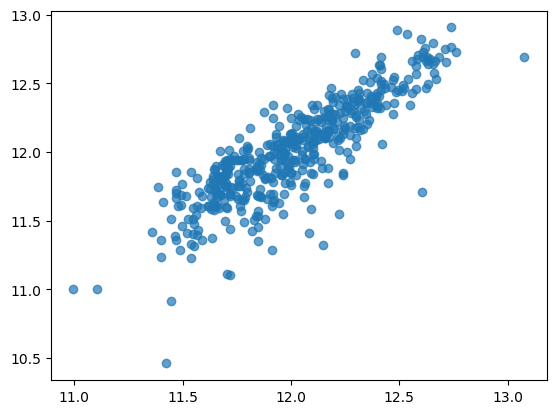

In [865]:
actual_values = y_test

plt.scatter(prediction, actual_values, alpha=0.7)



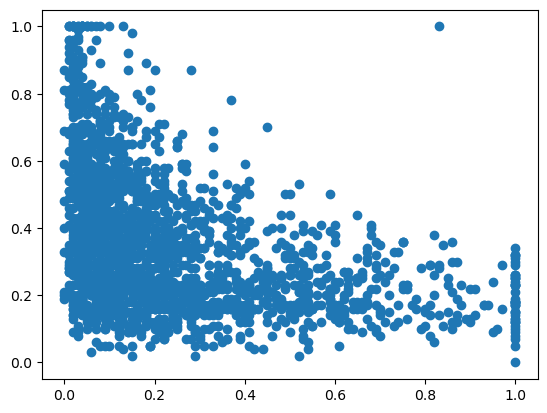

In [866]:
communities = pd.read_csv('censusCrime.csv')

independent = communities.medIncome

dependent = communities.ViolentCrimesPerPop

plt.scatter(dependent, independent)

In [867]:
communities_model = stats.linregress(dependent, independent)

communities_model

LinregressResult(slope=-0.38120877328328795, intercept=0.45184302867909665, rvalue=-0.4242206167261259, pvalue=6.334424808054381e-88, stderr=0.018232370529834566, intercept_stderr=0.006071371615729157)

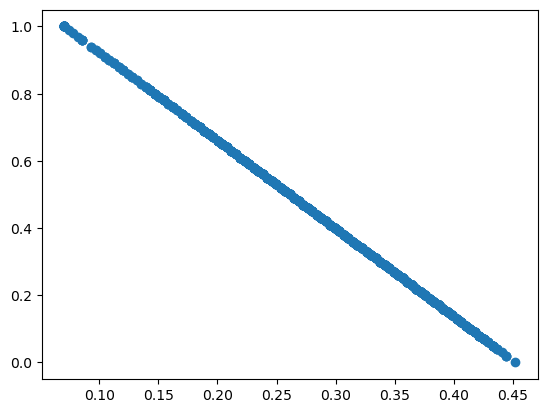

In [868]:
modelled_dependent = np.polyval([communities_model.slope, communities_model.intercept], independent)

plt.scatter(modelled_dependent, independent)

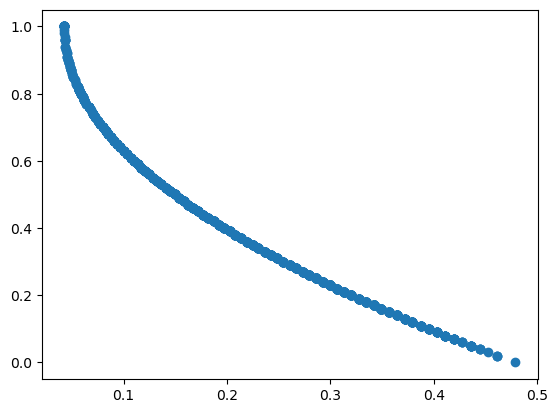

In [869]:
p_coeff = np.polyfit(independent, dependent, 2)

evaluated_curve = np.polyval(p_coeff, independent)

plt.scatter(evaluated_curve, independent)

In [871]:
numerical_data = communities.select_dtypes(include='number')

corr = numerical_data.corr()

print(corr['ViolentCrimesPerPop'].sort_values(ascending=False)[:10], '\n')



ViolentCrimesPerPop    1.000000
PctIlleg               0.737957
racepctblack           0.631264
pctWPubAsst            0.574665
FemalePctDiv           0.556032
TotalPctDiv            0.552777
MalePctDivorce         0.525407
PctPopUnderPov         0.521877
PctUnemployed          0.504235
PctHousNoPhone         0.488243
Name: ViolentCrimesPerPop, dtype: float64 



In [883]:
multi_independent = communities[['medIncome', 'PctIlleg']]

multi_model = sm.OLS(dependent, multi_independent)

results = multi_model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared (uncentered):                   0.771
Model:                             OLS   Adj. R-squared (uncentered):              0.770
Method:                  Least Squares   F-statistic:                              3346.
Date:                 Mon, 06 Nov 2023   Prob (F-statistic):                        0.00
Time:                         11:08:17   Log-Likelihood:                          831.17
No. Observations:                 1994   AIC:                                     -1658.
Df Residuals:                     1992   BIC:                                     -1647.
Df Model:                            2                                                  
Covariance Type:             nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
medIncome      0.0586      0.010      6.040      0.000       0.040       0.078
PctIlleg       0.8244      0.012     69.120      0.000       0.801       0.848
==============================================================================
Omnibus:                      304.750   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              947.152
Skew:                           0.773   Prob(JB):                    2.13e-206
Kurtosis:                       6.001   Cond. No.                         1.74
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""